# **PLEASE MAKE YOUR OWN COPY OF THIS NOTEBOOK**

# CIS 5450 Homework 2: SQL (Spring 2025)

**Due: Sunday, March 2nd, 10:00 PM EST**

**Total Points: 100 (69 Auto-graded + 31 Manually Graded)**

Welcome to Homework 2! By now, you should be familiar with the world of data science and the Pandas library. This assignment focuses on helping you get to grips with a new tool: SQL.

Through this homework, we will be working with SQL and DuckDB by exploring a [Yelp](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/versions/6) dataset containing business, checkin, tip, and user data. We will also conduct some text analysis.

 <!-- We will finish off the homework with some text analysis. -->

We are introducing a lot of new things in this homework, and this is often where students start to get lost. Thus, we **strongly** encourage you to review the slides/material as you work through this assignment.

**Before you begin:**
- Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the homework
- Check the **pinned FAQ post** on Ed for updates! If you have been stuck, chances are other students have also faced similar problems.



## Part 0: Libraries and Set Up Jargon (The usual wall of imports)
Run but do *not* edit these cells.

In [1]:
%set_env HW_ID=cis5450_sp25_HW2

env: HW_ID=cis5450_sp25_HW2


In [2]:
%%capture
!pip install penngrader-client

In [3]:
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido
!pip3 install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.38
    Uninstalling SQLAlchemy-2.0.38:
      Successfully uninstalled SQLAlchemy-2.0.38
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=c3bf268ed38ab39ede8bc6cb20aa211e450b532905940a39ec9d366cd8a184ae
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.1 MB/s eta 0:00:00


In [4]:
from penngrader.grader import *
import pandas as pd
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
import pandasql as ps #SQL on Pandas Dataframe
import duckdb

from matplotlib.dates import date2num
import matplotlib.pyplot as plt
import math
import re
import json
import os
from collections import Counter
import random

In [5]:
# Five datasets we're using
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_business.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_checkin.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_tip.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/yelp_user.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/hotel_reviews.csv

--2025-02-27 01:43:17--  https://storage.googleapis.com/penn-cis5450/yelp_business.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31760674 (30M) [text/csv]
Saving to: ‘yelp_business.csv’

yelp_business.csv   100%[===================>]  30.29M   173MB/s    in 0.2s    

2025-02-27 01:43:17 (173 MB/s) - ‘yelp_business.csv’ saved [31760674/31760674]

--2025-02-27 01:43:17--  https://storage.googleapis.com/penn-cis5450/yelp_checkin.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135964892 (130M) [text/csv]
Saving to: ‘yelp_checkin.csv’

yelp_checkin.csv    100

In [6]:
print(pd.__version__ )

2.2.2


###Setting up PennGrader###

In [7]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND

# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 73619426

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = "I leave early to go to figure skating lessons :)"

In [8]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [9]:
grader = PennGrader('notebook-config.yaml', "cis5450_sp25_HW2", STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 73619426

Make sure this correct or we will not be able to store your grade


We will use scores from Penn Grader to determine your grade. You will still need to submit your notebook so we can check for cheating and plagarism. Do not cheat.

**Note:** If you run Penn Grader after the due date for any question, your assignment will be marked late, even if you already had full points for the question before the deadline. To remedy this, if you're going to run your notebook after the deadline, either do not run the grading cells, or reinitialize the grader with an empty or clearly fake ID such as <code>999999999999</code> (please use 10+ digits to be clearly a fake <code>STUDENT_ID</code>)

# Yelp Dataset

<br>
<center><img src = "https://static-prod.adweek.com/wp-content/uploads/2021/08/YelpLogoAugust2021.jpg" width= "500" align ="center"/></center>
<br>



I'm sure you have used Yelp when searching for good restaurants or reliable local services, and with good reason. In this homework, we'll explore Yelp's extensive datasets to gain valuable insights into businesses and users on the platform. The data we will be using includes:

* Business: data about businesses listed on Yelp
* Check-in: data about check-ins made on businesses
* Tip: data about tips that users left for each business
* User: data about each user on Yelp including friends and number of reviews

We'll be parsing this data into dataframes and relations, and then exploring how to query and assemble the tables into results. We will primarily be using PandaSQL, but for some of the initial questions, we will ask you to perform the same operations in Pandas as well, so as to familiarize you with the differences and similarities of the two.

For the final part of this homework, we'll perform some text analysis on a hotel review dataset.

## Part 1: Load & Process our Datasets [12 points total]

Before we get into the data, we first need to load and clean our datasets.

# Metadata
You'll be working with four CSV files:
- `yelp_business.csv`
- `yelp_checkin.csv`
- `yelp_tip.csv`
- `yelp_user.csv`

The file `yelp_business.csv` contains data of businesses listed on Yelp such as name, address, stars, review count, etc.

The file `yelp_checkin.csv` contains check-in data for businesses including day, hour, and number of people.

The file `yelp_tip.csv` contains tips that each user left for each business.

The file `yelp_user.csv` contains data of each user such as name, review count, friends, start date of membership, and etc.


**TODO**:
* Load `yelp_business.csv` and save the data to a dataframe called `business_df`.
* Load `yelp_checkin.csv` and save the data to a dataframe called `checkin_df`.
* Load `yelp_tip.csv` and save the data to a dataframe called `tip_df`.
* Load `yelp_user.csv` and save the data to a dataframe called `user_df`.


In [10]:
# TODO: Import the datasets to pandas dataframes -- make sure the dataframes are named correctly!
business_df = pd.read_csv('yelp_business.csv')
checkin_df = pd.read_csv('yelp_checkin.csv')
tip_df = pd.read_csv('yelp_tip.csv')
user_df = pd.read_csv('yelp_user.csv')

### 1.1 Data Preprocessing

Next, we are going to want to clean up our dataframes. We will start with cleaning up `business_df`.

#### 1.1.1 Cleaning `business_df` [4 points]

`.info()` gives us meaningful information regarding columns, their types, and the amount of nulls, based on which we can now clean our dataframe.

Perform these steps and save results on a new dataframe: `business_cleaned_df`

**TODO**:
* Copy `business_df` to the new dataframe called `business_cleaned_df`
* Remove extra quotation marks from the entries in the columns `name` and `address` in `business_cleaned_df`
* Convert the column `categories` into a list of strings
* Drop `neighborhood` column from `business_cleaned_df`
* Create a column called `is_restaurant` where the value is 1 if `'Restaurants'` is in the list in column `categories` and is 0 otherwise
* Standardize the city column using **regex** by removing extra spaces and capitalizing each word (e.g., "Las Vegas", "Las  Vegas", and "las vegas" should all be standardized to "Las Vegas"). Use `.strip()` to help remove extra spaces, and `.title()` to capitalize.
* Sort `business_cleaned_df` by `business_id` in an ascending order, and reset index as well in order to drop old indices
* Create a list called `business_category_list` containing all unique values found in column `categories` and sort the list in an alphabetical order.

After performing these steps, `business_cleaned_df` should have the following schema:

**Final Schema**:
>business_id | name | address | city | state | postal_code | latitude | longitude | stars | review_count | is_open | categories | is_restaurant
>--- | --- | --- |--- | --- | --- | --- |--- | --- | --- |--- |--- |---

### **NOTES: MAKE SURE TO ALWAYS RESET INDEX. OTHERWISE, YOU MIGHT GET AN INTERNAL SERVER ERROR WHEN RUNNING THE TEST CASES!!!**

In [11]:
# View info of business_df
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   name          174567 non-null  object 
 2   neighborhood  68015 non-null   object 
 3   address       174567 non-null  object 
 4   city          174566 non-null  object 
 5   state         174566 non-null  object 
 6   postal_code   173944 non-null  object 
 7   latitude      174566 non-null  float64
 8   longitude     174566 non-null  float64
 9   stars         174567 non-null  float64
 10  review_count  174567 non-null  int64  
 11  is_open       174567 non-null  int64  
 12  categories    174567 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 17.3+ MB


In [12]:
# View first few rows of business_df
business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [13]:
# TODO: Create a copy of business_df called  business_cleaned_df
business_cleaned_df = business_df.copy()

In [14]:
# TODO: Remove extra quotations from name and address
business_cleaned_df['name'] = business_cleaned_df['name'].str.replace('"', '')
business_cleaned_df['address'] = business_cleaned_df['address'].str.replace('"', '')


In [15]:
# TODO: Convert categories into a list of strings
business_cleaned_df['categories'] = business_cleaned_df['categories'].str.split(';')


In [16]:
# TODO: Drop neighborhood column
business_cleaned_df = business_cleaned_df.drop(columns=['neighborhood'])


In [17]:
# TODO: Create a column called is_restaurant where the value is 1 if 'Restaurants' is within the list in the column categories and is 0 otherwise
business_cleaned_df['is_restaurant'] = business_cleaned_df['categories'].apply(lambda x: 1 if 'Restaurants' in x else 0)


In [18]:
# TODO: Standardize the city column using regex (remove extra spaces and capitalizing words)
business_cleaned_df['city'] = business_cleaned_df['city'].astype(str).str.strip().str.title() # Convert to string first
business_cleaned_df['city'] = business_cleaned_df['city'].apply(lambda x: re.sub(' +', ' ', x))


In [19]:
# TODO: Sort business_id by ascending order
business_cleaned_df = business_cleaned_df.sort_values(by='business_id').reset_index(drop=True)

In [20]:
# TODO: Create a list called business_category_list containing all unique values found in column categories and sort the list in an alphabetical order
business_category_list = sorted(list(set(business_cleaned_df['categories'].explode())))

In [21]:
len(business_category_list)

1294

In [22]:
# 4 points
grader.grade(test_case_id = 'test_cleaning_business', answer = (len(business_category_list), business_cleaned_df.head(5)))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.2 Cleaning `checkin_df` [3 points]

We will inspect `checkin_df` through the following steps:

**TODO**:
* Copy `checkin_df` to the new dataframe called `checkin_cleaned_df`
* Inspect the values in `weekday` column. Store the number of unique values for the column `weekday` in the variable called `weekday_count_checkin`
* Inspect the values in `hour` column. Store the number of unique values for the column `hour` in the variable called `hour_count_checkin`
* We would like to know the maximum TOTAL number of check-ins received by a business in the dataframe. Store this value in the variable called `max_checkin_single`

After performing these steps, `checkin_cleaned_df` should have the following schema (should be the same as `checkin_df`):

**Final Schema**:
>business_id | weekday | hour | checkins
>--- | --- | --- |---

In [23]:
# View info of checkin_df
checkin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911218 entries, 0 to 3911217
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   business_id  object
 1   weekday      object
 2   hour         object
 3   checkins     int64 
dtypes: int64(1), object(3)
memory usage: 119.4+ MB


In [24]:
# TODO: Create a copy of checkin_df called  checkin_cleaned_df
checkin_cleaned_df = checkin_df.copy()

In [25]:
# TODO: View checkin_cleaned_df
checkin_cleaned_df.head()

,business_id,weekday,hour,checkins
0,3Mc-LxcqeguOXOVT_2ZtCg,Tue,0:00,12
1,SVFx6_epO22bZTZnKwlX7g,Wed,0:00,4
2,vW9aLivd4-IorAfStzsHww,Tue,14:00,1
3,tEzxhauTQddACyqdJ0OPEQ,Fri,19:00,1
4,CEyZU32P-vtMhgqRCaXzMA,Tue,17:00,1


In [26]:
# TODO: Store the number of unique values for the column weekday in the variable called weekday_count_checkin
weekday_count_checkin = checkin_cleaned_df['weekday'].nunique()

In [27]:
# TODO: Store the number of unique values for the column hour in the variable called hour_count_checkin
hour_count_checkin = checkin_cleaned_df['hour'].nunique()

In [28]:
# TODO: Store the maximum number of check-ins for a single business in the variable called max_checkin_single
max_checkin_single = checkin_cleaned_df.groupby('business_id')['checkins'].sum().max()

In [29]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_checkin', answer = (weekday_count_checkin, hour_count_checkin, max_checkin_single))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.3 Cleaning `tip_df` [2 points]

We will clean `tip_df` through the following steps:

**TODO**:
* Copy `tip_df` to the new dataframe called `tip_cleaned_df`
* Drop all rows with NA
* Convert the data type in `date` column from string to `datetime64[ns]` (Use default format: `'%Y-%m-%d'`)
* Sort `tip_cleaned_df` by `business_id` and `user_id` in an ascending order and reset index

After performing these steps, `tip_cleaned_df` should have the following schema (should be the same as `tip_df`):

**Final Schema**:
>text | date | likes | business_id | user_id
>--- | --- | --- |--- |---

In [30]:
# View info of tip_df
tip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098324 entries, 0 to 1098323
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   text         1098319 non-null  object
 1   date         1098324 non-null  object
 2   likes        1098324 non-null  int64 
 3   business_id  1098324 non-null  object
 4   user_id      1098324 non-null  object
dtypes: int64(1), object(4)
memory usage: 41.9+ MB


In [31]:
# TODO: Create a copy of tip_df called tip_cleaned_df
tip_cleaned_df = tip_df.copy()

In [32]:
# TODO: Drop rows with NA
tip_cleaned_df = tip_cleaned_df.dropna()

In [33]:
# TODO: Convert the data in date column from string to datetime64[ns]
tip_cleaned_df['date'] = pd.to_datetime(tip_cleaned_df['date'], format='%Y-%m-%d')

In [34]:
# TODO: Sort tip_cleaned_df by business_id in an ascending order and reset index
tip_cleaned_df = tip_cleaned_df.sort_values(by=['business_id', 'user_id']).reset_index(drop=True)

In [35]:
# 2 points
grader.grade(test_case_id = 'test_cleaning_tip', answer = (tip_cleaned_df.head(5), len(tip_cleaned_df)))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.4 Cleaning `user_df` [3 points]

To understand what each column means, please refer to [this documentation](https://www.yelp.com/dataset/documentation/main) (Note that the original datasets were in JSON format).

Perform these steps and save results on a new dataframe: `user_cleaned_df`

**TODO**:
* Copy `user_df` to the new dataframe called `user_cleaned_df`
* Convert the type of the `friends` column to string, stripping excess spaces, and then convert the `friends` column to a list of strings.
* Create a column called `has_friend` which contains a value of 1 if the user has at least 1 friends and contains a value of 0 otherwise (read note below)
* Keep only these columns `user_cleaned_df`: `user_id, name, review_count, yelping_since, friends, elite, average_stars, has_friend`. (i.e. drop all others)
* Sort `user_cleaned_df` by `user_id` in an ascending order and reset index

After performing these steps, `user_cleaned_df` should have the following schema:

**Final Schema**:
>user_id | name | review_count | yelping_since | friends | elite | average_stars | has_friend
>--- | --- | --- |--- | --- | --- |--- |---


**Notes:**
* Do not convert the `friends` column into a list of strings since the table is very large, and performing such an operation could lead to a depletion of your RAM. We will address this column later, but only on a smaller subset of the table.
* `'None'` should not be interpreted as `NA` but rather a string `'None'`. After converting `'friends'` to type string, you should check for both `'None'` and `'nan'` with that spelling as indicators of having no friends.

In [36]:
# View info of user_df
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326100 entries, 0 to 1326099
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   user_id             1326100 non-null  object 
 1   name                1325585 non-null  object 
 2   review_count        1326100 non-null  int64  
 3   yelping_since       1326100 non-null  object 
 4   friends             760007 non-null   object 
 5   useful              1326100 non-null  int64  
 6   funny               1326100 non-null  int64  
 7   cool                1326100 non-null  int64  
 8   fans                1326100 non-null  int64  
 9   elite               60818 non-null    object 
 10  average_stars       1326100 non-null  float64
 11  compliment_hot      1326100 non-null  int64  
 12  compliment_more     1326100 non-null  int64  
 13  compliment_profile  1326100 non-null  int64  
 14  compliment_cute     1326100 non-null  int64  
 15  compliment_list

In [37]:
# TODO: Create a copy of user_df called user_cleaned_df
user_cleaned_df = user_df.copy()

In [38]:
# TODO: Strip the friends column of excess spaces and convert type to string.
user_cleaned_df['friends'] = user_cleaned_df['friends'].str.strip().astype(str)

In [39]:
# TODO: Create a column called has_friend which contains a value of 1 if the user has friends and 0 otherwise
user_cleaned_df['has_friend'] = user_cleaned_df['friends'].apply(lambda x: 0 if (x == 'None' or x == 'nan') else 1)


In [40]:
user_cleaned_df

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,has_friend
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,nan,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,nan,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,nan,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,nan,4,0,0,0,NaN,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326095,LODBIwiAcKxRi7Wz-sFsKw,Neth,1,2015-02-21,nan,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1326096,JpY2ozlb30z_AZCq2YX34g,Mike,1,2014-08-01,nan,2,0,0,0,NaN,...,0,0,0,0,0,0,0,0,1,0
1326097,AU9aZSA1rAjNE5cFcZTVMA,Jalin,12,2015-11-11,nan,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1326098,s1BZ7-rpqb3xRKcxvArXsQ,Cindy,33,2014-06-28,nan,5,0,0,0,NaN,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# TODO: Drop unwanted columns
user_cleaned_df = user_cleaned_df[['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'elite', 'average_stars', 'has_friend']]

In [42]:
# TODO: Sort by user_id in an ascending order
user_cleaned_df = user_cleaned_df.sort_values(by='user_id').reset_index(drop=True)

In [43]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_user', answer = (user_cleaned_df.head(5), len(user_cleaned_df)))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 2: Exploring the Data with DuckDB and SQL [63 points total]

### 👇👇👇 IMPORTANT: Pay VERY CLOSE attention to this style guide! 👇👇👇

The typical flow to use duckdb or pandasql (aliased as `ps`) is as follows:
1. Write a SQL query in the form of a string
    - **ALL SQL CLAUSES (`SELECT`, `FROM`, `WHERE`...) SHOULD BE CAPITALIZED!!!**. We would be checking the usage of certain clauses in your queries for partial credits and **they must be capitalized for you to receive credits**.
    - **String Syntax:** use triple quotes `"""<your query>"""` to write multi-line strings
    - **Aliases are your friend:** if there are very long table names or you find yourself needed to declare the source (common during join tasks), it's almost always optimal to alias your tables with short INTUITIVE alias names
    - **New Clauses New Line:** each of the main SQL clauses (`SELECT`, `FROM`, `WHERE`, etc.) should begin on a new line
    - **Use Indentation:** if there are many components for a single clause, separate them out with new <ins>indented</ins> lines.

    Example below:
    ```SQL
    """
    SELECT ltn.some_id, SUM(stn.some_value) AS total
    FROM long_table_name AS ltn
         INNER JOIN short_table_name AS stn
            ON ltn.common_key = stn.common_key
         INNER JOIN med_table_name AS mtn
            ON ltn.other_key = mtn.other_key
    WHERE ltn.col1 > value
         AND stn.col2 <= another_value
         AND mtn.col3 != something_else
    GROUP BY ltn.some_id
    ORDER BY total
    """
    ```
2. Run the query using **duckdb.sql(your_query)** or **ps.sqldf(your_query, locals())**

Duckdb and pandasql are convenient in that they allow you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the dataframes that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL that you are about to learn. SQL queries may take up to a minute to run.

**⚠WARNING: DO NOT USE PANDAS FOR SQL QUESTIONS OR VICE-VERSA! OTHERWISE, YOU WON'T RECEIVE CREDITS FOR THESE QUESTIONS**

In [44]:
#TODO: Run this cell to understand how Duck DB connects to local dataframes and queries them
test_duckdb_query = """
SELECT *
FROM tip_cleaned_df
LIMIT 10
"""

duckdb.sql(test_duckdb_query).df()

,text,date,likes,business_id,user_id
0,"$7.50 lunch special, dish of rice\/noodles wit...",2017-01-15,0,--6MefnULPED_I942VcFNA,0cUzu82KJiE5_xZA0Iu3ZQ
1,$5 lunch special,2014-07-11,0,--6MefnULPED_I942VcFNA,2oMkzQcRL7-d7URt3Xo_Xg
2,$6 lunch special. A lot of selection on the lu...,2015-02-19,0,--6MefnULPED_I942VcFNA,3yMtpQ_wV4ZGg6E69uE1PQ
3,"Combo A: Roast duck, roast pork, Singapore noo...",2015-10-12,0,--6MefnULPED_I942VcFNA,6tbXpUIU6upoeqWNDo9k_A
4,Make reservation on weekend,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
5,Great place for couple has $7.99 dish,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
6,King of bbq pork for $22,2013-01-27,0,--6MefnULPED_I942VcFNA,CxDOIDnH8gp9KXzpBHJYXw
7,BBQ pork is sold out early on Saturday,2013-03-23,0,--6MefnULPED_I942VcFNA,EiP1OFgs-XGcKZux0OKWIA
8,They only take cash.,2014-06-15,0,--6MefnULPED_I942VcFNA,Md9s_mb8Dxsl5MbjIp-DjQ
9,Cash only!! There's an ATM at the HSBC bank in...,2017-11-04,0,--6MefnULPED_I942VcFNA,RX9MH2jHaK90KF-2rU9Mvg


### 2.1 User Engagement Analytics

In this part, you will be asked to complete the tasks in both pandas and sql.

#### 2.1.1 Counting Tips Per User [6 points]

In this question, we would analyze how users engage with businesses by examining the number of tips they leave.

**TODO**:
* For each user, **count the total number of tips** they have left using `tip_cleaned_df`.
* Select the active users with over 100 tips.
* Display the following columns: `user_id`, `user_name`, and `total_tips`.
* **Order the final result by** `total_tips` in descending order, and `user_name` in ascending order.

For pandas, save the final result as `user_tips_df`, and for sql, save the final result as `user_tips_sql_df`.

**Final Schema**:
>user_id | user_name | total_tips  
>--- | --- | ---


In [45]:
# TODO: Count the total number of tips per user (pandas)

# Step 1: Count the number of tips per user
user_tips_count = tip_cleaned_df.groupby('user_id')['text'].count().reset_index()
user_tips_count = user_tips_count.rename(columns={'text': 'total_tips'})

# Step 2: Merge with user_cleaned_df to get user names
user_tips_df = pd.merge(user_tips_count, user_cleaned_df, on='user_id', how='inner')

# Step 3: Filter users with more than 100 tips
user_tips_df = user_tips_df[user_tips_df['total_tips'] > 100]

# Step 4: Select required columns, rename, and order by
user_tips_df = user_tips_df[['user_id', 'name', 'total_tips']]
user_tips_df = user_tips_df.rename(columns={'name': 'user_name'})
user_tips_df = user_tips_df.sort_values(by=['total_tips', 'user_name'], ascending=[False, True]).reset_index(drop=True)

In [46]:
# TODO: Count the total number of tips per user (SQL)
query_tips_per_user = '''
SELECT t.user_id,
       u.name AS user_name,
       COUNT(t.text) AS total_tips
FROM tip_cleaned_df AS t
JOIN user_cleaned_df AS u
    ON t.user_id = u.user_id
GROUP BY t.user_id, u.name
HAVING COUNT(t.text) > 100
ORDER BY total_tips DESC, user_name ASC

'''

# Execute query and save the result
user_tips_sql_df = duckdb.sql(query_tips_per_user).df()

In [47]:
# 6 points
grader.grade(test_case_id = 'test_counting_tips_per_user', answer = (user_tips_df, user_tips_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.2 Analyzing User Influence Through Tip Engagement [6 points]

Analyze how influential users are based on the **average number of likes per tip** and their engagement with **popular businesses**. Use `business_cleaned_df`.

**TODO**:
* For each active user identified in **2.1.1**, **calculate the average number of likes per tip** using the `tip_cleaned_df` table.
* **Determine how many of their tips were for highly-rated businesses** (businesses with over 4 stars from `business_cleaned_df`).
* Display the following columns: `user_id`, `user_name`, `average_likes_per_tip`, and `tips_for_high_rated_businesses`.
* **Order the final result by** `average_likes_per_tip` in descending order to highlight the most influential users, and `user_name` in ascending order.

**Hint**:
* Use **`COUNT()`** and **`CASE WHEN`** to filter for highly-rated businesses in one line. This is a common technique used in data analytics.

For pandas, save the final result as `user_influence_df`, and for sql, save the final result as `user_influence_sql_df`.


**Final Schema**:
>user_id | user_name | average_likes_per_tip | tips_for_high_rated_businesses  
>--- | --- | --- | ---

In [48]:
# TODO: Calculate the average likes per tip and count of tips for highly-rated businesses for active users (pandas)

# Step 1: Calculate average likes per tip
avg_likes_per_tip = tip_cleaned_df.groupby('user_id')['likes'].mean().reset_index()
avg_likes_per_tip = avg_likes_per_tip.rename(columns={'likes': 'average_likes_per_tip'})

# Step 2: Determine tips for highly-rated businesses
highly_rated_tips = pd.merge(tip_cleaned_df, business_cleaned_df[['business_id', 'stars']], on='business_id', how='inner')
highly_rated_tips = highly_rated_tips[highly_rated_tips['stars'] > 4]
highly_rated_tips_count = highly_rated_tips.groupby('user_id')['business_id'].count().reset_index()
highly_rated_tips_count = highly_rated_tips_count.rename(columns={'business_id': 'tips_for_high_rated_businesses'})

# Step 3: Merge with active users
user_influence_df = pd.merge(user_tips_df[['user_id', 'user_name']], avg_likes_per_tip, on='user_id', how='left')
user_influence_df = pd.merge(user_influence_df, highly_rated_tips_count, on='user_id', how='left')

user_influence_df['tips_for_high_rated_businesses'] = user_influence_df['tips_for_high_rated_businesses'].fillna(0)

# Step 4: Select required columns and order by

user_influence_df = user_influence_df[['user_id', 'user_name', 'average_likes_per_tip', 'tips_for_high_rated_businesses']]
user_influence_df = user_influence_df.sort_values(by=['average_likes_per_tip', 'user_name'], ascending=[False, True]).reset_index(drop=True)

In [49]:
user_influence_df

,user_id,user_name,average_likes_per_tip,tips_for_high_rated_businesses
0,mkbx55W8B8aPLgDqex7qgg,Momo,0.507087,690.0
1,wTfb2nfzPIyFcYQArdPtuQ,PrincessCandyEmpire,0.495868,32.0
2,Fv0e9RIV9jw5TX3ctA1WbA,Christie,0.416667,33.0
3,zFYs8gSUYDvXkb6O7YkRkw,Joyce,0.319588,100.0
4,R5WcogaoAwjdHxrB2v5NsQ,Bonnie,0.292906,125.0
...,...,...,...,...
1004,6871p_keaXVB8ly3xqk2pA,grace,0.000000,34.0
1005,k1yP9hHka_xg-AW14M8V0Q,jeremy,0.000000,11.0
1006,GJ1jUThFFIPFSixgzsrVtw,ralph,0.000000,19.0
1007,Ed_E_fBL8VCSF60_Uv5bmw,sandy,0.000000,38.0


In [50]:
# TODO: Calculate the average likes per tip and count of tips for highly-rated businesses for active users (sql)
query_user_influence = '''

SELECT t.user_id,
       u.name AS user_name,
       AVG(t.likes) AS average_likes_per_tip,
       SUM(CASE WHEN b.stars > 4 THEN 1 ELSE 0 END) AS tips_for_high_rated_businesses
FROM tip_cleaned_df AS t
JOIN user_cleaned_df AS u
    ON t.user_id = u.user_id
JOIN business_cleaned_df AS b
    ON t.business_id = b.business_id
WHERE t.user_id IN (SELECT user_id FROM user_tips_df) -- Filter for active users
GROUP BY t.user_id, u.name
ORDER BY average_likes_per_tip DESC, user_name ASC

'''

# Execute query and save the result
user_influence_sql_df = duckdb.sql(query_user_influence).df()

In [51]:
# 6 points
grader.grade(test_case_id = 'test_user_influence', answer = (user_influence_df, user_influence_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.3 Are Reviewers on Average Positive or Negative? [6 points]

Do people who leave restaurant reviews tend to be on average **pessimistic** or **optimistic**? Let's analyze the average star ratings of users who leave tips for restaurants.

**TODO**:
* Use `tip_cleaned_df`, `business_cleaned_df`, and `user_cleaned_df` to calculate the **average rating** of all Yelp users who have left a tip/review on a **restaurant**.
* Make sure that each user is **counted only once** when calculating the average rating, even if they left multiple tips or reviews. (Hint: use **DISTINCT**)
* Display the final result as a **one-column, one-row dataframe** showing the average user rating.

For pandas, save the final result as `average_rating_tip_df`, and for sql, save the final result as `average_rating_tip_sql_df`. Finally, save your query in `query_average_rating_tip`.

**Final Schema**:
>average_stars |
>--- |

In [52]:
# TODO: Calculate the average rating of all Yelp reviewers who left a tip for a restaurant (pandas)

# Step 1: merge tip_cleaned_df and business_cleaned_df
merged_df = pd.merge(tip_cleaned_df, business_cleaned_df, on='business_id', how='inner')

# Step 2: get only restaurants
restaurant_tips = merged_df[merged_df['is_restaurant'] == 1]

# Step 3: drop duplicates
distinct_users = restaurant_tips[['user_id']].drop_duplicates()

# Step 4: merge distinct_users and user_cleaned_df
user_ratings = pd.merge(distinct_users, user_cleaned_df, on='user_id', how='inner')

# Step 5: recreate df

average_rating_tip_df = pd.DataFrame(user_ratings['average_stars'].mean(), columns=['average_stars'], index=[0])

In [53]:
# TODO: Calculate the average rating of all Yelp reviewers who left a tip for a restaurant (sql)
query_average_rating_tip = '''

SELECT AVG(u.average_stars) AS average_stars
FROM user_cleaned_df AS u
WHERE u.user_id IN (
    SELECT DISTINCT t.user_id
    FROM tip_cleaned_df AS t
    JOIN business_cleaned_df AS b
        ON t.business_id = b.business_id
    WHERE b.is_restaurant = 1)

'''

# Execute query and save the result
average_rating_tip_sql_df = duckdb.sql(query_average_rating_tip).df()

In [54]:
# 6 points
grader.grade(test_case_id='test_average_rating_tip', answer=(query_average_rating_tip, average_rating_tip_df, average_rating_tip_sql_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.4 City with Highest Tips per User [6 points]

Figure out what are the top cities are in which users on average tip the most.

**TODO:**

* Use `tip_cleaned_df` table with the `business_cleaned_df` table to find how the tips are related with its city.
* Calculate the average number of tips per user for each city by dividing the total number of tips by the number of unique users.
* Order the final result by `avg_tips_per_user` in descending order.
* Make sure that a particular city has over 1000 unique users
* Round `avg_tips_per_user` to the third decimal point

**Hint:**

* Ensure you have distinct users




Final Schema:

>city|	total_tips|	unique_users|	avg_tips_per_user
>--- | --- | --- | ---


In [55]:

# Step 1: Join tip_cleaned_df with business_cleaned_df
tip_city_df = pd.merge(tip_cleaned_df, business_cleaned_df[['business_id', 'city']], on='business_id', how='inner')

# Step 2: Group by city and calculate:
# - total_tips and unique_users
city_top_tip_per_user_df_pd = tip_city_df.groupby('city').agg(
    total_tips=('user_id', 'count'),
    unique_users=('user_id', 'nunique')
).reset_index()

# Step 3: Calculate the average tips per user for each city and round to 3 decimal places.
city_top_tip_per_user_df_pd['avg_tips_per_user'] = (city_top_tip_per_user_df_pd['total_tips'] / city_top_tip_per_user_df_pd['unique_users']).round(3)

# Step 4: Filter the results to include only cities with more than 1000 unique users.
city_top_tip_per_user_df_pd = city_top_tip_per_user_df_pd[city_top_tip_per_user_df_pd['unique_users'] > 1000]
# Step 5: Order the final result by avg_tips_per_user in descending order.

city_top_tip_per_user_df_pd = city_top_tip_per_user_df_pd.sort_values(by='avg_tips_per_user', ascending=False).reset_index(drop=True)

In [56]:
city_top_tip_per_user = '''

SELECT b.city,
       COUNT(t.business_id) AS total_tips,
       COUNT(DISTINCT t.user_id) AS unique_users,
       ROUND(CAST(COUNT(t.business_id) AS REAL) / COUNT(DISTINCT t.user_id), 3) AS avg_tips_per_user
FROM tip_cleaned_df AS t
JOIN business_cleaned_df AS b
    ON t.business_id = b.business_id
GROUP BY b.city
HAVING COUNT(DISTINCT t.user_id) > 1000
ORDER BY avg_tips_per_user DESC

'''

city_top_tip_per_user_df = duckdb.sql(city_top_tip_per_user).df()

In [57]:
# 6 points
grader.grade(test_case_id='test_city_tip', answer=(city_top_tip_per_user, city_top_tip_per_user_df_pd, city_top_tip_per_user_df))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2 Temporal Patterns: Analyzing Trends Over Time

For the rest of the assignment, we will only be using **SQL**.

#### 2.2.1 Seasonal Trends in User Tip Activity [5 points] (3 manually graded points)

Analyze **when users are most active** in leaving tips by examining both **yearly and monthly trends**.

**TODO**:
* Extract the **year** and **month** from the `date` column in the `tip_cleaned_df` using `strftime(t.date, '%Y')` and `strftime(t.date, '%m')`.
* **Filter** the results to include only years between **2011** to **2014**.
* Calculate the **total number of tips left for each year and month** combination.
* **Display**: `year`, `month`, `total_tips`.
* **Order the result by** `year` and `month` in ascending order.

**Hint**:
* Look into using `strftime()` to extract year and month.

Save the final result as `yearly_monthly_tips_df`.

**Final Schema**:
>year | month | total_tips  
>--- | --- | ---

In [58]:
# TODO: Calculate the total number of tips per year and month
query_yearly_monthly_tips = '''
SELECT strftime(t.date, '%Y') AS year,
       strftime(t.date, '%m') AS month,
       COUNT(*) AS total_tips
FROM tip_cleaned_df AS t
WHERE CAST(strftime(t.date, '%Y') AS INTEGER) BETWEEN 2011 AND 2014
GROUP BY year, month
ORDER BY year, month

'''

# Execute query and save the result
yearly_monthly_tips_df = duckdb.sql(query_yearly_monthly_tips).df()

In [59]:
# 2 points
grader.grade(test_case_id='test_seasonal_trends_in_tips', answer=yearly_monthly_tips_df)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, **visualize** the trend using a **line plot** to identify seasonal patterns across different months of our period of interest. Make sure to have the graph very clearly labeled. You can use a library of your choice. Briefly explain the trend you observed. **[3 manually graded points]**

Your graph should have:

* Clear title and axis labels (Year-Month on X axis and Total Tips on Y axis)
* Adequate figure size to show clearly the trend
* Adjusted spacing to prevent any figure overlappings

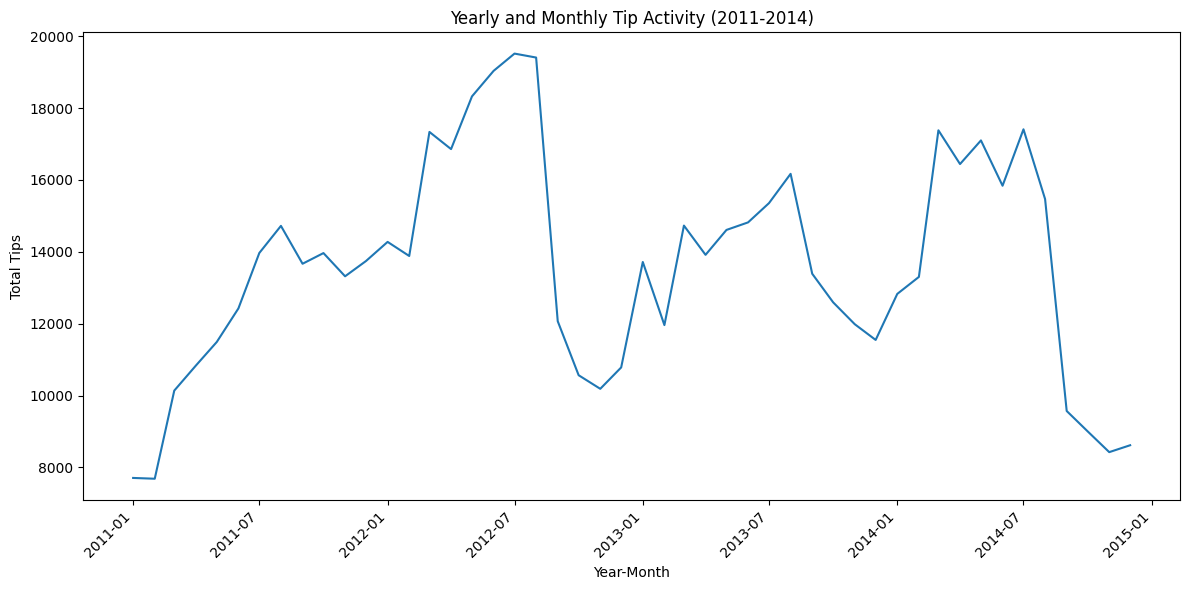

In [60]:
# TODO: Visualize the yearly and monthly tip activity
import matplotlib.pyplot as plt

# Convert 'year' and 'month' columns to datetime objects for plotting
yearly_monthly_tips_df['year_month'] = pd.to_datetime(yearly_monthly_tips_df['year'].astype(str) + '-' + yearly_monthly_tips_df['month'].astype(str) + '-01')

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization
plt.plot(yearly_monthly_tips_df['year_month'], yearly_monthly_tips_df['total_tips'])

# Set title and labels
plt.title('Yearly and Monthly Tip Activity (2011-2014)')
plt.xlabel('Year-Month')
plt.ylabel('Total Tips')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust spacing to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


**Your Observations:** The graph visualises seasonal trends in user tip activity via a line graph over four years of data. The x-axis represents time as year-month, in increments of 6 month periods across 4 years, 2011 to 2015. The y-axis represents the total number of tips per month (year-month) combination. In terms of the graph trend, there is an absolute maximum at 2017-07, and an absolute minimum at 2011-01 and 2011-02. There does not seem to be any skew in the data, it is rather varied, but one might identify four main peaks in the data (three main dips).

#### 2.2.2 Rolling Average of Monthly Business Reviews [7 points] (3 manually graded points)

Analyze **monthly review activity** to identify long-term patterns and fluctuations in user engagement.

**Note: Although this problem is quite involved in concept, the ultimate answer should not be long.**

**TODO**:
* Extract the **year** and **month** from the `date` column in `tip_cleaned_df`.
* Calculate the **total number of reviews left per month** **between 2014 and 2016**.
* Compute a **3-month rolling average** of reviews to smooth out fluctuations and highlight consistent trends.
* Round the rolling average to two decimal points.
* **Display**: `year`, `month`, `total_reviews`, `rolling_avg_reviews`.
* **Order the result by** `year` and `month` in ascending order.

**Hint**:
* Look into the SQL **window functions** (`ROWS BETWEEN`) to calculate the rolling average.
* The **rolling average** here takes the **current month's value**, along with the **two previous months' values**, and calculates their **average**.
* Understand the logic of how window functions like **`OVER`** work can help with the problem.
* **A valid 3-month rolling average** means that for a given row representing month `m`, the result is calculated as:

  $$ \text{Rolling Average} = \frac{\text{Value for Month } m + \text{Value for Month } (m-1) + \text{Value for Month } (m-2)}{3} $$

Save the final result as `monthly_review_trends_df`. Save your query as `query_review_trends`.

**Final Schema**:
>year | month | total_reviews | rolling_avg_reviews  
>--- | --- | --- | ---

In [61]:
# TODO: Calculate total monthly reviews and compute rolling averages
query_monthly_reviews = '''

WITH MonthlyReviews AS (
    SELECT
        strftime('%Y', date) AS year,
        strftime('%m', date) AS month,
        COUNT(*) AS total_reviews
    FROM tip_cleaned_df
    WHERE CAST(strftime('%Y', date) AS INTEGER) BETWEEN 2014 AND 2016
    GROUP BY year, month
)
SELECT
    year,
    month,
    total_reviews,
    ROUND(AVG(total_reviews) OVER (ORDER BY year, month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW), 2) AS rolling_avg_reviews
FROM MonthlyReviews
ORDER BY year, month;
'''

# Execute query and save the result
monthly_review_trends_df = duckdb.sql(query_monthly_reviews).df()

In [62]:
# 4 points
grader.grade(test_case_id='test_rolling_avg_monthly_reviews', answer = (query_monthly_reviews, monthly_review_trends_df))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, **visualize** the trend using a **line plot**. Include the trend for total reviews and rolling averages in two lines. Make sure to have the graph very clearly labeled. Briefly explain some potential advantages of using rolling averages from the graph. **[3 manually graded points]**

Your graph should have:

* Clear title and axis labels (Year-Month on X axis and Number of Reviews on Y axis)
* Two separate lines within one line plot with different labels
* Adequate figure size to show clearly the comparisons
* Adjusted spacing to prevent any figure overlappings

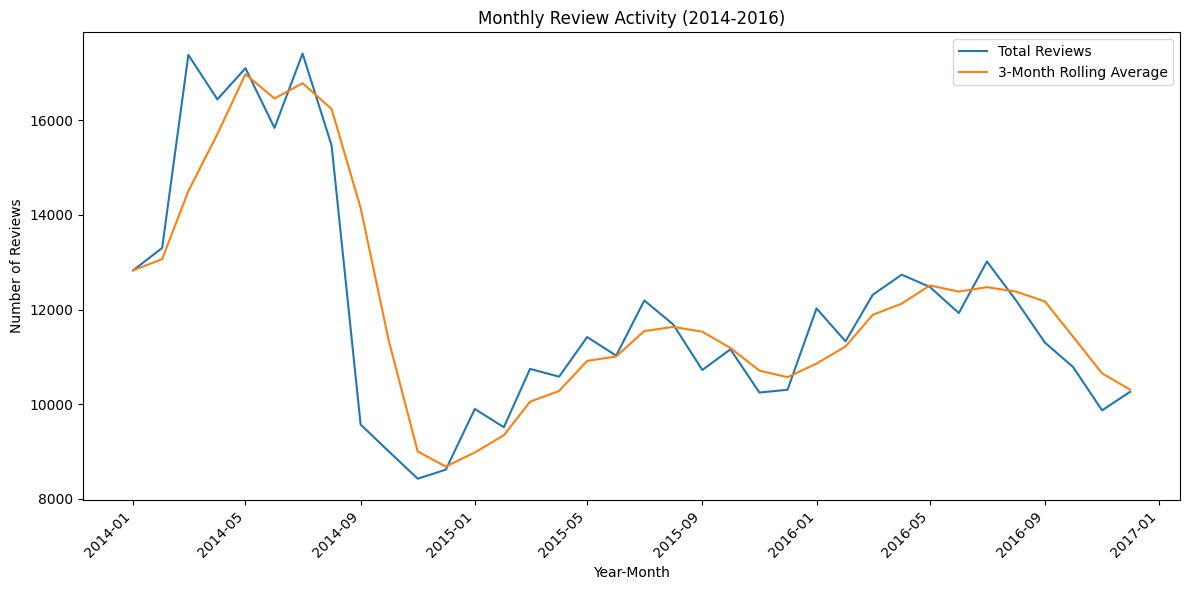

In [63]:
# TODO: Visualize the trend of total reviews and rolling averages

import matplotlib.pyplot as plt

# Convert 'year' and 'month' columns to datetime objects for plotting
monthly_review_trends_df['year_month'] = pd.to_datetime(monthly_review_trends_df['year'].astype(str) + '-' + monthly_review_trends_df['month'].astype(str) + '-01')

# Create the line plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization

# Plot total reviews
plt.plot(monthly_review_trends_df['year_month'], monthly_review_trends_df['total_reviews'], label='Total Reviews')

# Plot rolling averages
plt.plot(monthly_review_trends_df['year_month'], monthly_review_trends_df['rolling_avg_reviews'], label='3-Month Rolling Average')

# Set title and labels
plt.title('Monthly Review Activity (2014-2016)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust spacing to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

**Your Observations:** The graph visualises total reviews and rolling average trends in user review activity via a line graph over three years of data. The x-axis represents time as year-month, in increments of 4 month periods (yearly quarters) across 3 years, 2014 to 2017. The y-axis represents the total number of reveiws per month (year-month) combination. In terms of the graph trend, there is an absolute maximum at 2014-07, and an absolute minimum at 2014-11. There does seem to be a rightward (positive) skew in the data, though the tail of said skew displays a few peaks and dips. One might identify three main peaks in the data (and three main dips).

### 2.3 Business Performance Analytics

#### 2.3.1 Identifying Top Restaurants by City [4 points]

In this question, we analyze the performance of restaurants across different cities using ratings, reviews, and check-ins. We would be first using `business_cleaned_df`.

**TODO**:
* Identify the **top 3 restaurants in each city** with the highest **average star ratings**.
  * Only include restaurants that have **more than 50 reviews** and are currently **open** (`is_open = 1`).
  * Display: `business_id`, `business_name`, `city`, `stars`, and `review_count`.
  * **Order the final result by** `city` in ascending order, `stars` in descending order, and `review_count` in descending order.

**Hint**:
* Use a CTE for calculation and then filter for the top 3 of each city.
* Use the **`ROW_NUMBER()`** window function to rank businesses within each city.

Save the final result as `top_restaurants_df`. Save your final query as `query_top_restaurant`.

**Final Schema**:
>business_id | business_name | city | stars | review_count  
>--- | --- | --- | --- | ---


In [64]:
# TODO: Identify the top 3 restaurants in each city with >50 reviews and open
query_top_restaurant = '''

WITH RankedRestaurants AS (
    SELECT
        business_id,
        name AS business_name,
        city,
        stars,
        review_count,
        ROW_NUMBER() OVER (PARTITION BY city ORDER BY stars DESC, review_count DESC) AS rank_within_city
    FROM business_cleaned_df
    WHERE is_restaurant = 1 AND review_count > 50 AND is_open = 1
)
SELECT
    business_id,
    business_name,
    city,
    stars,
    review_count
FROM RankedRestaurants
WHERE rank_within_city <= 3
ORDER BY city, stars DESC, review_count DESC;

'''

# Execute query and save the result
top_restaurants_df = duckdb.sql(query_top_restaurant).df()

In [65]:
# 4 points
grader.grade(test_case_id='test_top_restaurants_by_city', answer=(query_top_restaurant, top_restaurants_df))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.2 Analyzing Check-In Performance [5 points]

Analyze the check-in performance of the top restaurants identified in **2.3.1**.

**TODO**:
* For each restaurant identified in **2.3.1**, calculate the **total number of check-ins** using the `checkin_cleaned_df` table.
* Compare each restaurant's total check-ins to the **average check-ins** of all restaurants in the same city.
* Use a **`CASE WHEN`** statement to label restaurants as `'Above Average'` or `'Below Average'` based on their total check-ins compared to the city average. Store it in `checkin_performance`.
* **Display**: `business_id`, `business_name`, `city`, `total_checkins`, `checkin_performance`.
* **Order the final result by** `checkin_performance` in ascending order and `total_checkins` in descending order.

**Hint**:
* First create a **CTE** that calculates the total check-ins for each business.
* You can look into the **CASE WHEN** function to label comparisons.

Save the final result as `checkin_performance_df`. Save the final query as `query_checkin_performace`.

**Final Schema**:
>business_id | business_name | city | total_checkins | checkin_performance  
>--- | --- | --- | --- | ---

In [66]:
# TODO: Calculate total check-ins and compare with city average
query_checkin_performace ='''

WITH BusinessCheckins AS (
    SELECT
        business_id,
        SUM(checkins) AS total_checkins
    FROM checkin_cleaned_df
    GROUP BY business_id
),
CityAvgCheckins AS (
    SELECT
        b.city,
        AVG(bc.total_checkins) AS avg_city_checkins
    FROM BusinessCheckins bc
    JOIN business_cleaned_df b ON bc.business_id = b.business_id
    GROUP BY b.city
)
SELECT
    tr.business_id,
    tr.business_name,
    tr.city,
    bc.total_checkins,
    CASE
        WHEN bc.total_checkins > cac.avg_city_checkins THEN 'Above Average'
        ELSE 'Below Average'
    END AS checkin_performance
FROM top_restaurants_df tr
JOIN BusinessCheckins bc ON tr.business_id = bc.business_id
JOIN CityAvgCheckins cac ON tr.city = cac.city
ORDER BY checkin_performance, total_checkins DESC;

'''

# Execute query and save the result
checkin_performance_df = duckdb.sql(query_checkin_performace).df()

In [67]:
# 5 points
grader.grade(test_case_id='test_checkin_performance', answer=(query_checkin_performace, checkin_performance_df))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.3 Analyzing Review Trends Over Time [5 points]

Analyze how the **number of reviews** for the top restaurants identified in **2.3.1** has changed over time using the `tip_cleaned_df` table.

**TODO**:
* For each restaurant identified in **2.3.1**, **count the number of reviews per year** using the `tip_cleaned_df` table.
* **Filter** the results to include only restaurants located in **Paradise Valley** and in the years **2013 to 2017**.
* Compare the number of reviews year-over-year to determine if review activity is **increasing**, **decreasing**, or **stable**.
* Label each year's trend as `'Increasing'`, `'Decreasing'`, or `'Stable'` based on comparison with the previous year. (If there is no data for the previous year, label the trend as 'Stable')
* **Display**: `business_id`, `business_name`, `year`, `review_count`, `review_trend`.
* **Order the final result by** `business_name` and `year` in ascending order.

**Hint**:
* Create a **CTE** to count reviews per year for each restaurant.
* Use **`CAST(strftime(tip_cleaned_df.date, '%Y') AS INTEGER)`** to extract and filter the year from the review date.
* Look into the **`LAG()`** window function to compare the current year's review count with the previous year's.
* Use **`CASE WHEN()`** to determine trend

Save the final result as `review_trends_df`. Save the final query as `query_review_trends`.

**Final Schema**:
>business_id | business_name | year | review_count | review_trend  
>--- | --- | --- | --- | ---

In [68]:
# TODO: Analyze review trends over time
query_review_trends = '''

WITH YearlyReviews AS (
    SELECT
        tr.business_id,
        tr.business_name,
        CAST(strftime(t.date, '%Y') AS INTEGER) AS year,
        COUNT(*) AS review_count
    FROM top_restaurants_df tr
    JOIN tip_cleaned_df t ON tr.business_id = t.business_id
    WHERE tr.city = 'Paradise Valley' AND CAST(strftime(t.date, '%Y') AS INTEGER) BETWEEN 2013 AND 2017
    GROUP BY tr.business_id, tr.business_name, year
)
SELECT
    business_id,
    business_name,
    year,
    review_count,
    CASE
        WHEN review_count > LAG(review_count) OVER (PARTITION BY business_id ORDER BY year) THEN 'Increasing'
        WHEN review_count < LAG(review_count) OVER (PARTITION BY business_id ORDER BY year) THEN 'Decreasing'
        ELSE 'Stable'
    END AS review_trend
FROM YearlyReviews
ORDER BY business_name, year;

'''

# Execute query and save the result
review_trends_df = duckdb.sql(query_review_trends).df()

In [69]:
review_trends_df

,business_id,business_name,year,review_count,review_trend
0,sWwCwjsd27k0Y8m1RIWZEg,El Chorro,2013,9,Stable
1,sWwCwjsd27k0Y8m1RIWZEg,El Chorro,2014,6,Decreasing
2,sWwCwjsd27k0Y8m1RIWZEg,El Chorro,2015,11,Increasing
3,sWwCwjsd27k0Y8m1RIWZEg,El Chorro,2016,2,Decreasing
4,sWwCwjsd27k0Y8m1RIWZEg,El Chorro,2017,4,Increasing
5,OtGSQQzV7uF8XPAsNIh7Bw,Elements,2013,6,Stable
6,OtGSQQzV7uF8XPAsNIh7Bw,Elements,2014,5,Decreasing
7,OtGSQQzV7uF8XPAsNIh7Bw,Elements,2015,1,Decreasing
8,OtGSQQzV7uF8XPAsNIh7Bw,Elements,2016,4,Increasing
9,OtGSQQzV7uF8XPAsNIh7Bw,Elements,2017,5,Increasing


In [70]:
# 5 points
grader.grade(test_case_id='test_review_trends', answer=(query_review_trends, review_trends_df))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.4 Analyzing Tip-to-Check-In Ratio [8 points]

Create a dataframe to analyze the restaurants in the Yelp Database with the 10 highest tip-to-check-in ratio. This is to analyze which restaurants and cities have very high engagement online compared to its number of check ins. This might imply an area with a lot of Yelp presence.


**TODO:**

- For each business, **calculate the total number of tips** using the `tip_cleaned_df` table.
- For each business, **calculate the total number of check-ins** using the `checkin_cleaned_df` table.
- **Join** these results with the `business_cleaned_df` table to obtain the business name and city.
- **Compute** the engagement ratio for each business by dividing the total tip count by the total check-in count.  
  - **Note:** Use a `CASE WHEN` statement to handle cases with zero check-ins by setting the ratio to 0.
- **Aggregate** the engagement ratio for each city to calculate the average engagement ratio per city.
- For each business, **compare** its engagement ratio to the city average:
  - Label the business as `'High Engagement'` if its ratio is at least 10% above the city average.
  - Label it as `'Low Engagement'` if its ratio is at least 10% below the city average.
  - Otherwise, label it as `'Average Engagement'`.
- **Display** the final result with the following columns:  
  `business_id`, `business_name`, `city`, `tip_count`, `checkin_count`, `tip_checkin_ratio`, `city_avg_ratio`, `engagement_label`.
- **Order** the final result by `tip_checkin_ratio` (descending) and keep the top 10. Ensure that `tip_checkin_ratio` and `city_average_ratio` is rounded to 3 decimal digits. Filter out any restaurants with `tip_count` less than or equal to 200

**Hint:**

- Create a **CTE** to aggregate tip counts from `tip_cleaned_df`.
- Create another **CTE** to aggregate check-in counts from `checkin_cleaned_df`.
- Join these CTEs with `business_cleaned_df` to form a business-level engagement table. Think about what type of join.
* **MAKE SURE TO HANDLE THE NULL VALUES BY MAKING IT 0, AND IF `CHECK_IN_COUNT` IS 0, THEN SET TIP_CHECKIN_RATIO OF THAT PLACE TO 0, ELSE ROUND IT** to 3 decimal digits
- Use a **CTE** to calculate the city-level average engagement ratio.
- Apply a **CASE WHEN** statement to compare each business’s ratio against its city average.
- Save the final result as `engagement_performance_df` and the final query as `query_engagement_performance`.

**Final Schema:**

| business_id | business_name | city | tip_count | checkin_count | tip_checkin_ratio | city_avg_ratio | engagement_label |
| ----------- | ------------- | ---- | --------- | ------------- | ----------------- | -------------- | ---------------- |

In [71]:
tip_to_check_in = '''

WITH BusinessTips AS (
    SELECT business_id, COUNT(*) AS tip_count
    FROM tip_cleaned_df
    GROUP BY business_id
),
BusinessCheckins AS (
    SELECT business_id, COUNT(*) AS checkin_count
    FROM checkin_cleaned_df
    GROUP BY business_id
),

CityAvgRatio AS (
    SELECT city, ROUND(AVG(CASE WHEN checkin_count = 0 THEN 0
    WHEN checkin_count IS NULL THEN 0
    ELSE ROUND(tip_count / checkin_count, 3)
END), 3) as city_avg_ratio
    FROM business_cleaned_df b
    LEFT JOIN BusinessTips bt ON b.business_id = bt.business_id
    LEFT JOIN BusinessCheckins bc ON b.business_id = bc.business_id
    WHERE is_restaurant = 1
    GROUP BY city
)

SELECT b.business_id, b.name AS business_name, b.city, bt.tip_count, bc.checkin_count,
CASE WHEN checkin_count = 0 THEN 0
    WHEN checkin_count IS NULL THEN 0
    ELSE ROUND(tip_count / checkin_count, 3)
END AS tip_checkin_ratio,
car.city_avg_ratio,
 CASE
        WHEN tip_checkin_ratio >= car.city_avg_ratio * 1.1 THEN 'High Engagement'
        WHEN tip_checkin_ratio <= car.city_avg_ratio * 0.9 THEN 'Low Engagement'
        ELSE 'Average Engagement'
    END AS engagement_label

FROM business_cleaned_df b
LEFT JOIN BusinessTips bt ON b.business_id = bt.business_id
LEFT JOIN BusinessCheckins bc ON b.business_id = bc.business_id
LEFT JOIN CityAvgRatio car ON b.city = car.city
WHERE tip_count > 200 AND is_restaurant = 1
ORDER BY tip_checkin_ratio DESC
LIMIT 10;
'''

# Execute query and save the result
tip_to_check_in_df = duckdb.sql(tip_to_check_in).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [72]:
tip_to_check_in_df

,business_id,business_name,city,tip_count,checkin_count,tip_checkin_ratio,city_avg_ratio,engagement_label
0,hihud--QRriCYZw1zZvW4g,Gangnam Asian BBQ Dining,Las Vegas,1287,143,9.000,0.485,High Engagement
1,DkYS3arLOhA8si5uUEmHOw,Earl of Sandwich,Las Vegas,1474,168,8.774,0.485,High Engagement
2,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,Las Vegas,1346,161,8.360,0.485,High Engagement
3,UPIYuRaZvknINOd1w8kqRQ,Monta Ramen,Las Vegas,959,133,7.211,0.485,High Engagement
4,RESDUcs7fIiihp38-d6_6g,Bacchanal Buffet,Las Vegas,1149,167,6.880,0.485,High Engagement
5,7sPNbCx7vGAaH7SbNPZ6oA,Bachi Burger,Las Vegas,981,143,6.860,0.485,High Engagement
6,LNGBEEelQx4zbfWnlc66cw,Studio B Buffet,Henderson,854,133,6.421,0.475,High Engagement
7,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,Las Vegas,1038,164,6.329,0.485,High Engagement
8,yfxDa8RFOvJPQh0rNtakHA,Pho Kim Long,Las Vegas,1062,168,6.321,0.485,High Engagement
9,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,1033,166,6.223,0.485,High Engagement


In [73]:
# 8 points
grader.grade(test_case_id='test_tip_checkin', answer=(tip_to_check_in_df))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.5 Identify users who review businesses with low tips. [5 points]

**TODO**:
* Keep businesses with less than 3 tips and greater than 100 reviews.
* Idenfity users who have reviewed these businesses and calculate the number of reviews they have placed on these businesses as `num_reviews`.
* Order the final result by `num_reviews` in descending order, and `user_name` in ascending order.

**Hint**:
* Create multiple **CTE**'s.

Save the final result as `niche_reviewers_df`.

**Final Schema**:
>user_id | user_name | num_reviews
>--- | --- | ---

In [74]:
query_niche_reviewers = '''
WITH LowTipBusinesses AS (
    SELECT business_id
    FROM business_cleaned_df
    WHERE review_count > 100

    INTERSECT

    SELECT business_id
    FROM (SELECT business_id, COUNT(*) AS tip_count FROM tip_cleaned_df GROUP BY business_id)
    WHERE tip_count < 3
),
UserReviewsOnLowTipBusinesses AS (
    SELECT
        u.user_id,
        u.name AS user_name,
        COUNT(*) AS num_reviews
    FROM user_cleaned_df u
    JOIN tip_cleaned_df t ON u.user_id = t.user_id
    JOIN LowTipBusinesses ltb ON t.business_id = ltb.business_id
    GROUP BY u.user_id, u.name
)
SELECT
    user_id,
    user_name,
    num_reviews
FROM UserReviewsOnLowTipBusinesses
ORDER BY num_reviews DESC, user_name;

'''

niche_reviewers_df = duckdb.sql(query_niche_reviewers).df()

In [75]:
# 5 points
grader.grade(test_case_id='test_niche_reviewers', answer=niche_reviewers_df)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Part 3: Schema Design [25 points manually graded]

## 3.1 Functional Dependencies (5 points manually graded)


Let  $A, B, C, D, E, F$  all be attributes in our schema.

Use Armstrong's axioms to prove that if:

$AB \rightarrow C$, $C \rightarrow D$, $DE \rightarrow F$, and $E \rightarrow B$, then $AB \rightarrow F$.

Review Lecture 6 (Relational schema) slide 50 if you need a refresher on Armstrong's axioms.

Armstrong's axioms: reflexivity, augmentation, and transitivity
Proving $AB \rightarrow F$ given the following functional dependencies:

$
AB \rightarrow C, \quad C \rightarrow D, \quad DE \rightarrow F, \quad E \rightarrow B.
$

##Apply Transitivity on  $ AB \rightarrow C$ and $C \rightarrow D$
We're given:

$AB \rightarrow C \quad \text{and} \quad C \rightarrow D $

by transitivity:

$
AB \rightarrow D.
$


##Use Augmentation on $ AB \rightarrow D$ with $E$
By augmentation, adding $ E $ to both sides:

$ABE \rightarrow DE.$

##Apply Transitivity on $ ABE \rightarrow DE $ and $ DE \rightarrow F $
We have:

$
ABE \rightarrow DE \quad \text{and} \quad DE \rightarrow F,
$

by transitivity:

$
ABE \rightarrow F.
$

##Express $ ABE $ in Terms of $ AB $
It remains to show that $ AB $ is sufficient. We are given:

$
E \rightarrow B,
$

by augmentation with $ A $:

$
AE \rightarrow AB.
$

Since $ AB $ contains itself, this means $ AB $ already determines $ ABE $, so:

$
AB \rightarrow ABE.
$

##Apply Transitivity on $ AB \rightarrow ABE $ and $ ABE \rightarrow F $
Now:

$
AB \rightarrow ABE \quad \text{and} \quad ABE \rightarrow F,
$

applying transitivity:

$
AB \rightarrow F.
$

Thus, we have successfully proven that $ AB \rightarrow F $ using Armstrong's axioms.

## 3.2 3NF (10 points manually graded)


**Please answer the following question in the markdown cell below.**

Suppose $R = {A, B, C, D, E}$, and we have the following set of functional dependencies:

$A \rightarrow BC$

$B \rightarrow C$

$B \rightarrow D$

$C \rightarrow E$

Decompose $R$ into third normal form (3NF). Clearly mark the relations in your final answer, and specify their primary key.

## Finding Candidate Key(s)
- Compute A⁺:

 - $A \rightarrow BC$
 - $B \rightarrow C$ (already covered)
 - $B \rightarrow D$ (now have A, B, C, D)
 - $C \rightarrow E$ (now have A, B, C, D, E)

  Since A⁺ = {A, B, C, D, E}, the candidate key is **A**.

##Identifying 3NF Violations
- $A \rightarrow BC$ :Valid, a is a candidate key
- $B \rightarrow C$ :Violation, B is not a superkey, C is not prime
- $B \rightarrow D$ :Violation, B is not a superkey, D is not prime
- $C \rightarrow E$ :Violation, C is not a superkey, E is not prime

##Decompose into 3NF
1. **$R_1(A, B, C)$**  :Covers A → BC, Primary Key: A
2. **$R_2(B, D)$**  :Covers B → D, Primary Key: B
3. **$R_3(C, E)$**  :Covers C → E, Primary Key: C

##Final Relations:
- R₁(A, B, C): Primary Key, A
- R₂(B, D):  Primary Key, B
- R₃(C, E):  Primary Key, C

This decomposition ensures 3NF while preserving dependencies and lossless decomposition.


## 3.3 Entity Relationship Design (10 points manually graded)


**Please answer the following question in the markdown cell below by uploading an image of your solution. You can do this by:**


1. Upload images from your local machine by clicking on the files icon in the left sidebar
2. Click the **Upload** button
3. Select the image you want to upload after the file upload dialogue appears

GO EAGLES!!! Consider a NFL database that must be designed to manage players, coaches, and subteams. The system should be designed to capture the following requirements:

1. Every player has a unique player ID (e.g. 033), name (e.g. Cooper DeJean), position (cornerback), and age (22).
2. Every subteam has a unique subteam ID (e.g. 002), subteam code (e.g. Eagles-D1), and name (e.g. Eagles Defensive Unit A).
3. Each coach has a unique coach ID (e.g. 007), name (e.g. Vic Fangio), and title (e.g. Defensive Coordinator).
4. Players can be in multiple subteams.
5. Each subteam can have just one coach, but a coach can lead multiple subteams.

Carefully consider the relationships that exist between players and subteams, and subteams and coaches.

Design an ER diagram that captures the relationships above. Be sure to capture all entities, relationships, and cardinalities.

In [77]:
# Mount drive to give colab access to your other files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


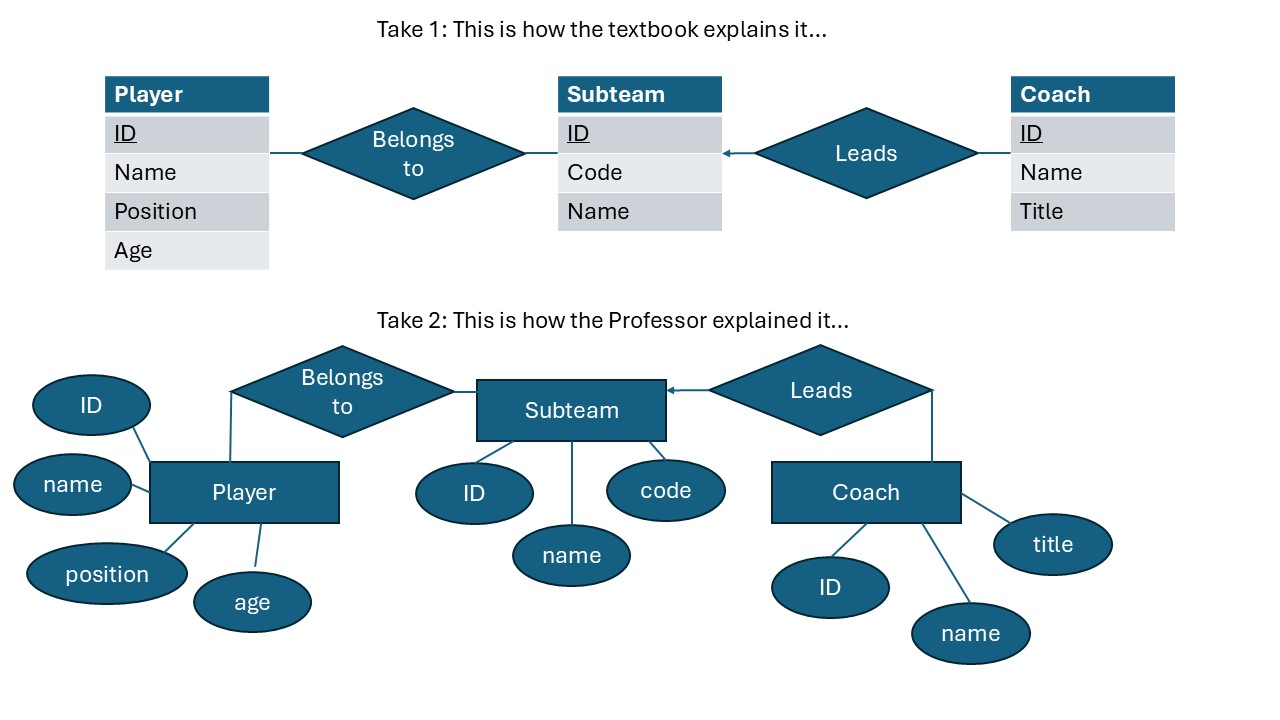

In [85]:
from PIL import Image
from IPython.display import display

img = Image.open('hw1.jpg')
img.show()
display(img)

# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):


1.   Restart and Run-All to make sure there's nothing wrong with your notebook
2.   **Double check that you have the correct PennID (all numbers) in the autograder**.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and download both the .ipynb and .py files, renaming them as "homework2.ipynb" and "homework2.py" respectively. Upload both files to Gradescope directly!
5. Check your .ipynb file is visible under the code tab. If there is a "large file error" go back and delete all occurances of printing an entire df, and/or make your figure sizes smaller, then resubmit. Then confirm the notebook preview is now visible in your Gradescope submission.

**You MUST check that your notebook displays ALL visualizations on the Gradescope preview AND verify that the autograder finishes running and gives you your expected score (not a 0).**

**Let the course staff know ASAP if you have any issues submitting, but otherwise best of luck! Congrats on finishing the HW.**